In [1]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]



In [2]:
simsnames

['6.96e11', '8.26e11', '7.08e11', '1.12e12', '2.79e12', '7.55e11']

In [3]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob

In [5]:
from itertools import combinations_with_replacement
import matplotlib
from scipy import interpolate
from scipy.interpolate import interp1d
def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange[:-1]), vmax=max(vrange[:-1]))
    return [cmap(norm(i)) for i in vrange]



# get true slope
def getISMevolution(ISMdata, numofbins=15):
    agebin = np.linspace(min(ISMdata['time']),max(ISMdata['time']),numofbins+1)
    slopes_ism = np.zeros(len(agebin)-1)
    splitR = np.linspace(0,10,6)
    ismcols = ISMdata.columns[1:]
    strres = np.zeros(len(agebin)-1)
    for i in range(len(agebin)-1):
        feh_ism=np.zeros(len(splitR)-1)
        for j in range(len(splitR)-1):
            m = ((ISMdata['time']>agebin[i])&(ISMdata['time']<agebin[i+1]))
            feh_ism[j] = np.mean(ISMdata[ismcols[j]][m].dropna())
        z, strres[i] = np.polyfit(splitR[:-1]+np.diff(splitR)[0], feh_ism, 1, full=True)[:2]
        p = np.poly1d(z)
        slopes_ism[i]=p[1]

    f_slope = interpolate.interp1d((agebin[:-1]+np.diff(agebin)[0]/2),slopes_ism, kind='cubic')
    f_feh = interpolate.interp1d(ISMdata['time'],ISMdata[ismcols[-2]])
    return agebin[:-1]+np.diff(agebin)[0]/2, f_slope, f_feh, strres




def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    return data

def calcISM(sim, splitR=np.linspace(0,10,6), disk=False):
    
    print(sim)
    simsname = sim.split('_')[0]
    allsnaps = glob.glob(sim+'/*.?????')
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    allsnaps_time = sorted(allsnaps_time)
    
    if disk:
        f = open(simsname+'_ISM_disk.txt', "w")
        f_w = open(simsname+'_weights_disk.txt', "w")
    else:
        f = open(simsname+'_ISM.txt', "w")
        f_w = open(simsname+'_weights.txt', "w")
    headerf = 'time,'
    for i in range(len(splitR)-1):
        rbin = str(splitR[i])+'-'+str(splitR[i+1])
        if i == len(splitR)-2:
             headerf = headerf+rbin+'\n'
        else:
            headerf = headerf+rbin+','
    f.write(headerf)
    f.flush()
    
    
    simNo=simsname
    Rcut=True
    Rcut_thread=30
    zcut_thread=5

    print('Reading in simulation...')
    data_z0 = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=disk)
    print('Finished reading in simulation...')
    
    
    count=0
    for i in trange(len(allsnaps_time)):
        s = pb.load(snaplookup[allsnaps_time[i]])
        s.physical_units()
        ages = s.properties['time']
        h=s.halos()
        try:
            h[1]
        except:
            print("Can't find halo for snapshot "+snaplookup[allsnaps_time[i]])
            continue
        pb.analysis.angmom.faceon(h[1])

        gal = pb.filt.LowPass('r', '25 kpc') & pb.filt.BandPass('z', '-2.5 kpc', '2.5 kpc')
        sim = h[1][gal]
    
        stars = sim.g
        
        if len(stars)==0:
            print('No stars in this snapshot!')
            continue
        
        cols = ['feh','x','y']
        try:
            this_snap = {j:stars[j] for j in cols}
        except:
            print('No gas')
            continue
    
        data = pd.DataFrame(this_snap)
        data['R'] = np.sqrt(data['x']**2+data['y']**2)
        data = data.dropna(subset=['feh'])
        
        nextlinef = str(ages).split(' ')[0]
        for j in range(len(splitR)-1):
            locstar = data.loc[(data['R']>splitR[j])&(data['R']<splitR[j+1])].reset_index(drop=True)
            nextlinef = nextlinef+','+str(np.mean(locstar['feh']))
        print(nextlinef)
        f.write(nextlinef+'\n')
        f.flush()
        
        ############################ analyze stars ############################
        stars = sim.s
        cols = ['feh','x','y','iord']
        try:
            this_snap = {j:stars[j] for j in cols}
        except:
            print('No stars')
            continue
        if len(stars)<1000:
            print('Not enough stars!')
            continue
        data = pd.DataFrame(this_snap)
        data['R'] = np.sqrt(data['x']**2+data['y']**2)
        data = data.dropna(subset=['feh'])
        data = pd.merge(data, data_z0[['Rbir', 'age', 'iord']], 
                        left_on='iord', right_on='iord',how='inner')
        
        
        #print('Calculating weights...')
        try:
            allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
            scat = np.std(y-ypred)
            bias  = np.mean(y-ypred)
        except:
            print("can't get weights for feh and age!")
            continue
        #print(len(allnames), len(weights))
        #print('Finished calculating weights...')
        
            
        #print('Calculating weights with R...')
        try:
            allnames_wR, weights_wR, weights_err_wR, y_wR, ypred_wR = calcRbir_cv_withR(data)
            scat_wR = np.std(y_wR-ypred_wR)
            bias_wR  = np.mean(y_wR-ypred_wR)
        except:
            print("can't get weights for feh, R, and age!")
            continue
        #print('Finished calculating weights...')

        if count==0:
            firstline = 'time'
            for kk in range(len(allnames)):
                firstline = firstline+','+allnames[kk]
                firstline = firstline+','+allnames[kk]+'_err'
                
            for kk in range(len(allnames_wR)):
                firstline = firstline+','+allnames_wR[kk]+'_wR'
                firstline = firstline+','+allnames_wR[kk]+'_wR_err'
            firstline = firstline+','+'scatter,bias,scatter_err,bias_err\n'
            
            f_w.write(firstline)
            f_w.flush()
            count=count+1
            continue
        
        linewrite = str(ages).split(' ')[0]
        for kk in range(len(allnames)):
            linewrite = linewrite+','+str(weights[kk])
            linewrite = linewrite+','+str(weights_err[kk])

        for kk in range(len(allnames_wR)):
            linewrite = linewrite+','+str(weights_wR[kk])
            linewrite = linewrite+','+str(weights_err_wR[kk])
        linewrite = linewrite+','+str(scat)+','+str(bias)+','+str(scat_wR)+','+str(bias_wR)+'\n'
        f_w.write(linewrite)
        f_w.flush() 
            

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:06<00:33,  6.79s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


 33%|███▎      | 2/6 [00:15<00:31,  7.88s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:26<00:28,  9.47s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


 83%|████████▎ | 5/6 [00:41<00:08,  8.19s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


100%|██████████| 6/6 [00:48<00:00,  8.07s/it]


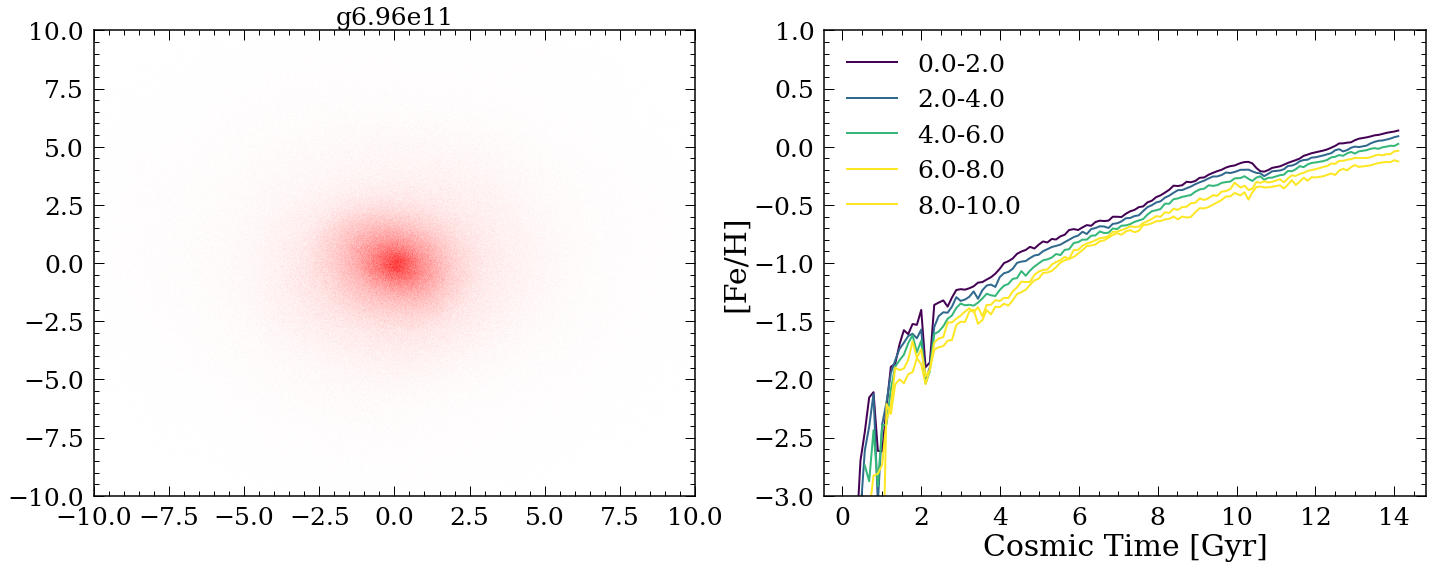

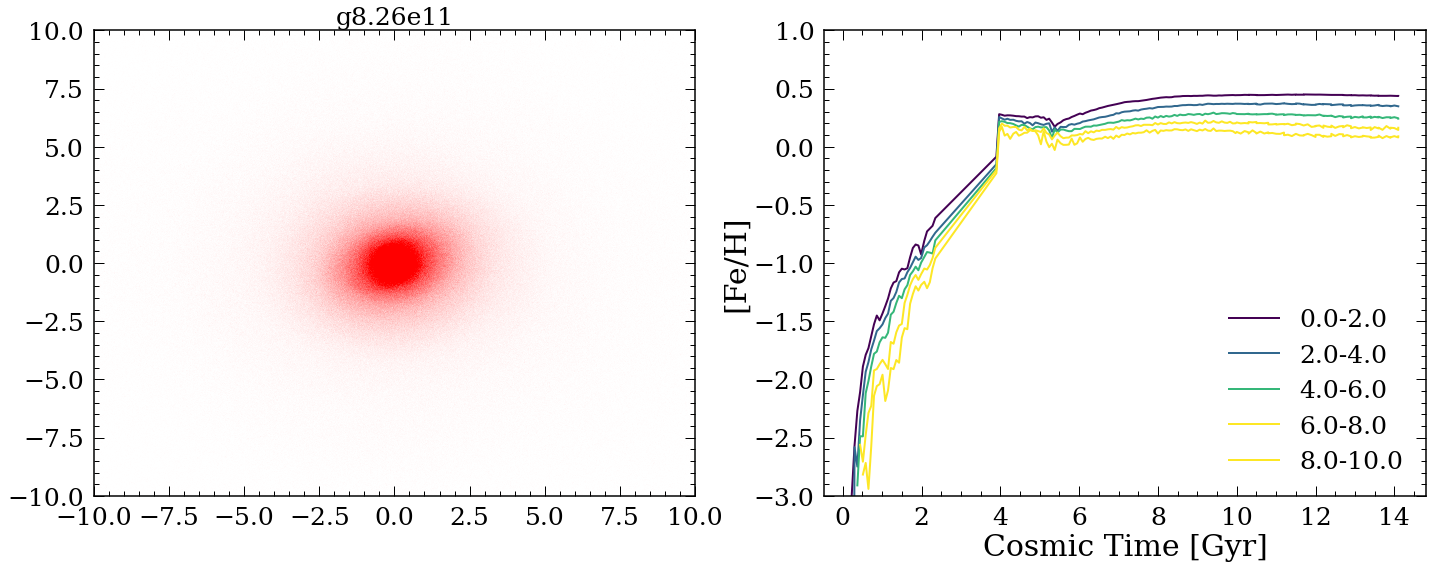

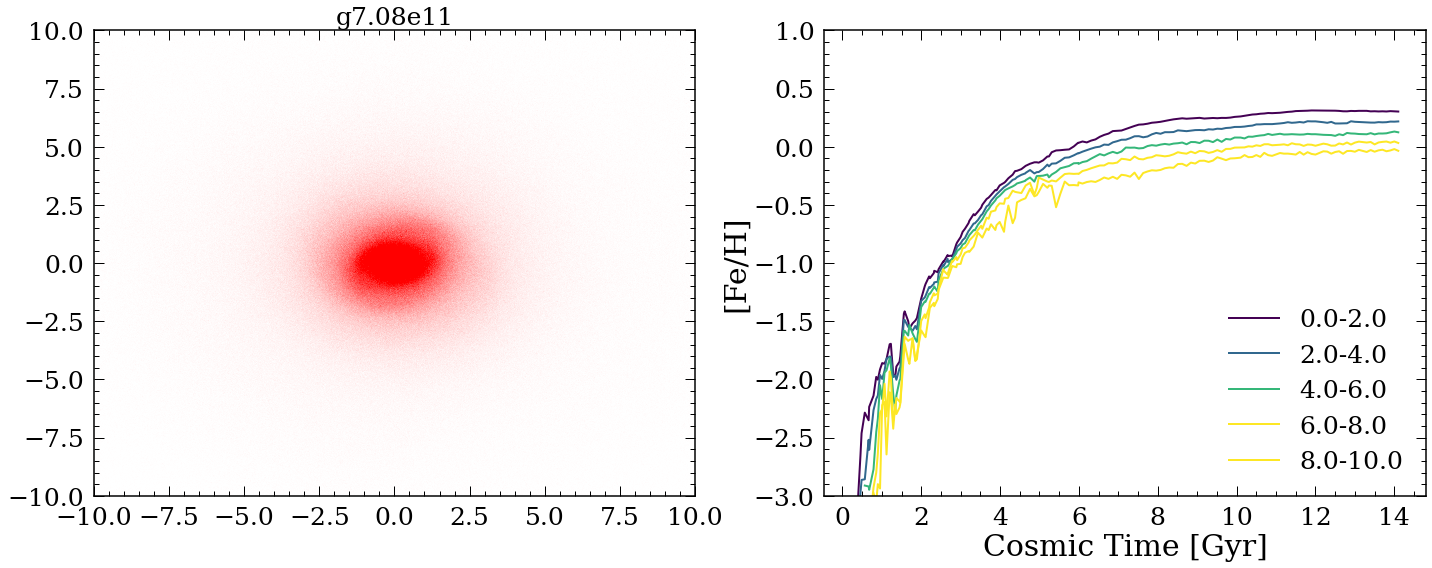

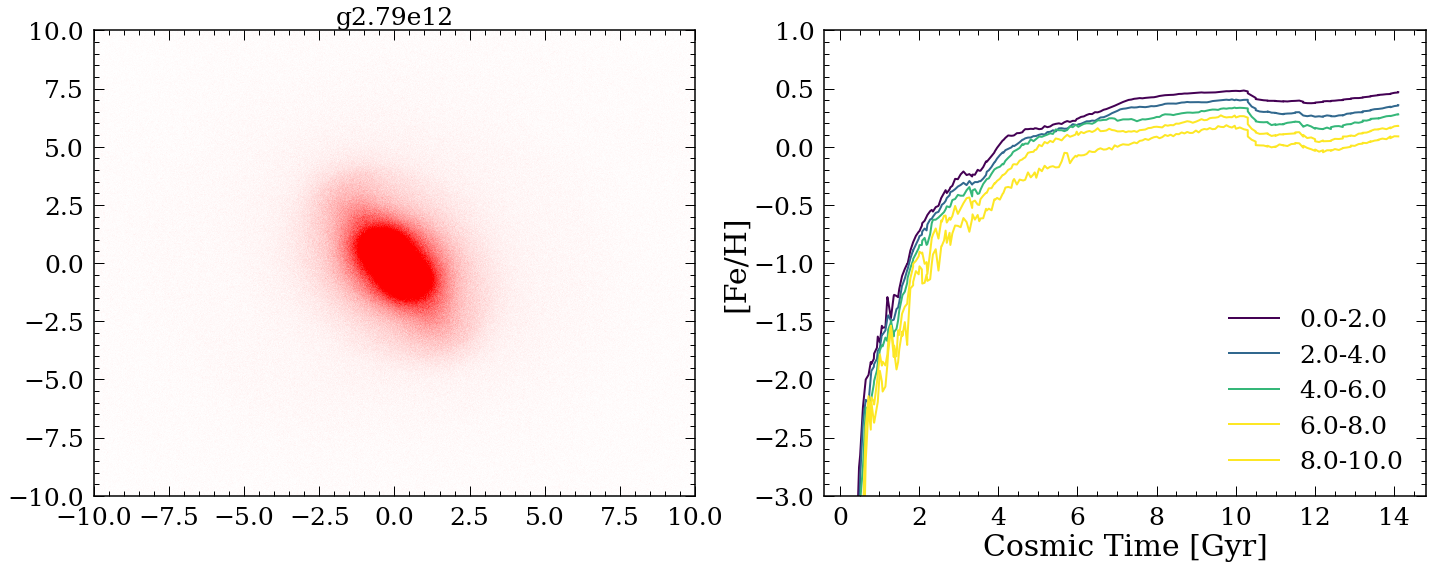

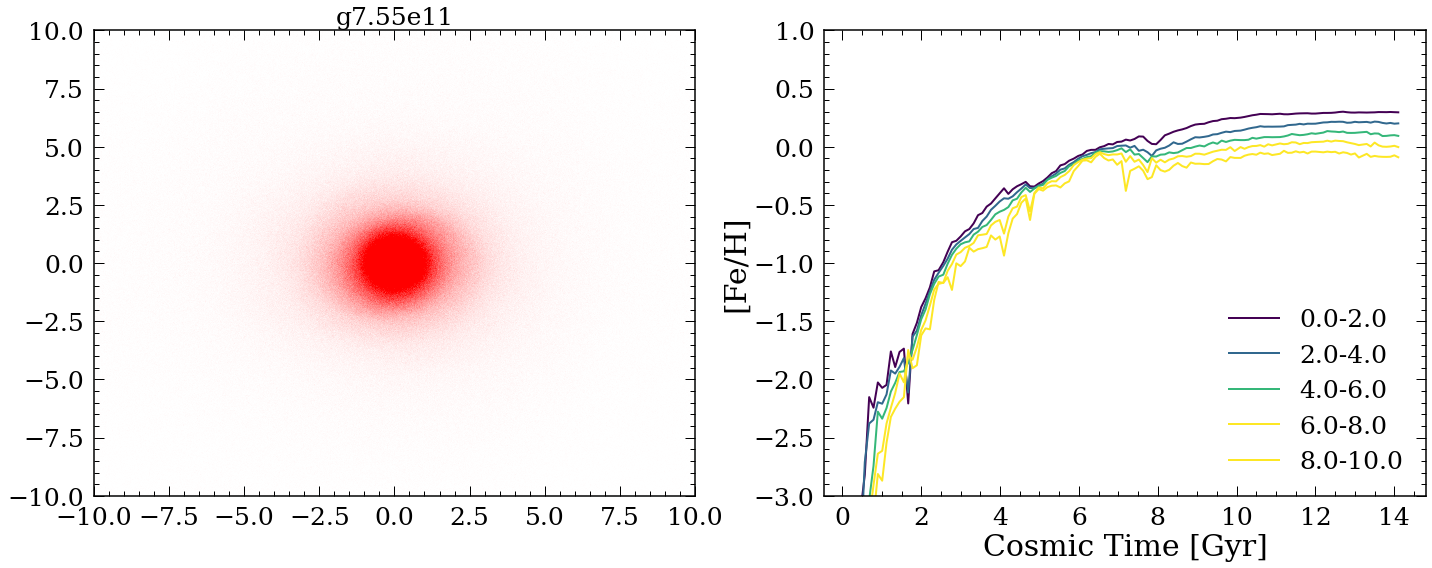

In [27]:

colors = getcolor(range(5))

allages = np.zeros((len(simsnames), 100))*np.nan
allfeh = np.zeros((len(simsnames), 100))*np.nan
allfeh_slope = np.zeros((len(simsnames), 100))*np.nan
lsqs = np.zeros((len(simsnames), 15))*np.nan

for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=30
    zcut_thread=5

    print('Reading in simulation...')
    data = readsimdata('g'+simNo,Rcut,Rcut_thread,zcut_thread,disk=True)
    print('Finished reading in simulation...')
    
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.scatter(data['x'], data['y'], s=0.01, c='r', alpha=0.01)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.title('g%s'%simsnames[i], fontsize=25)
    
    plt.subplot(1,2,2)
    try:
        filename = 'g'+simsnames[i]+'_ISM.txt'
        ism = pd.read_table(filename, delimiter=',')
    except:
        try:
            filename = 'g'+simsnames[i]+'_ISM_disk.txt'
            ism = pd.read_table(filename, delimiter=',')
        except:
            continue
        continue
    ismcolumsn = ism.columns
    
    
    for j in range(5):
        plt.plot(ism['time'],ism[ismcolumsn[j+1]],color=colors[j], label = ismcolumsn[j+1])
    plt.legend()
    plt.ylim([-3,1])
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('[Fe/H]')
    plt.tight_layout()
    
    
    agebin, f_slope, f_feh, strres = getISMevolution(ism)
    minagebin, maxagebin = min(agebin), max(agebin)
    
    allages[i, :] = np.linspace(minagebin,maxagebin,100)
    allfeh[i, :] = f_feh(np.linspace(minagebin,maxagebin,100))
    allfeh_slope[i, :] = f_slope(np.linspace(minagebin,maxagebin,100))
    lsqs[i, :] = strres
    
    

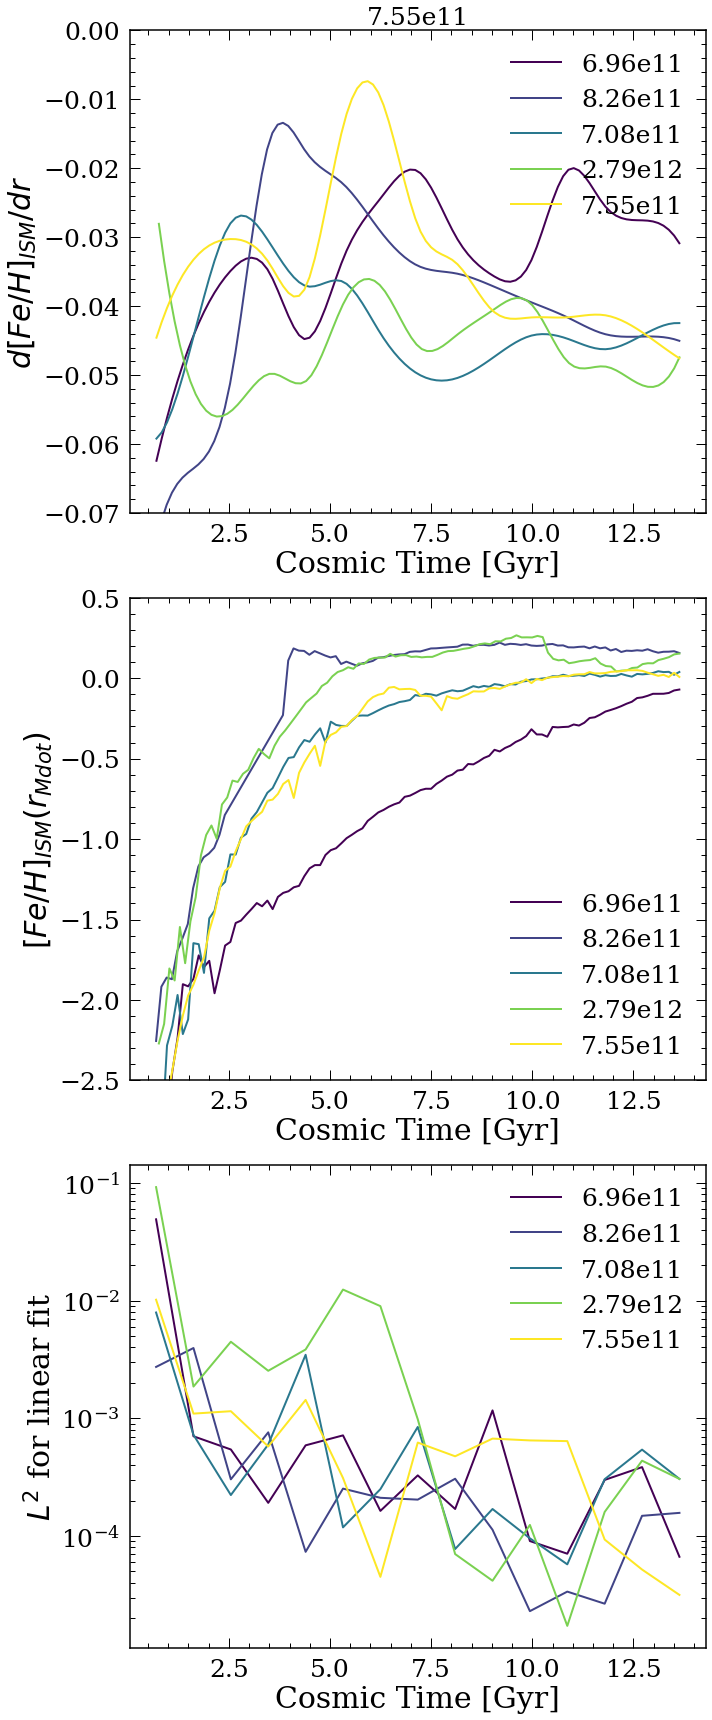

In [28]:
colors = getcolor(range(len(simsnames)+1))
plt.figure(figsize=(10,24))
for i in range(len(simsnames)):
    if simsnames[i] == '1.12e12':
        continue
    plt.subplot(3,1,1)
    plt.plot(allages[i,:],allfeh_slope[i,:],
             '-',color=colors[i],label=simsnames[i])
    plt.ylim([-0.07,0])
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('$d[Fe/H]_{ISM}/dr$')
    plt.legend()
    plt.title(simsnames[i], fontsize=25)

    plt.subplot(3,1,2)
    plt.plot(allages[i,:],allfeh[i,:],
            '-',color=colors[i],label=simsnames[i])
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('$[Fe/H]_{ISM}(r_{Mdot})$')
    plt.ylim([-2.5,0.5])
    plt.legend()
    plt.tight_layout()

    plt.subplot(3,1,3)
    plt.semilogy(agebin, lsqs[i,:], '-',color=colors[i],label=simsnames[i])
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('$L^2$ for linear fit')
    plt.legend()
    plt.tight_layout()




In [64]:
sim = sims[4]
print(sim)
simsname = sim.split('_')[0]
allsnaps = glob.glob(sim+'/*.?????')

allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

allsnaps_time = sorted(allsnaps_time)
allages_ism = np.zeros(len(allsnaps_time))

for i in trange(len(allsnaps_time)):
    s = pb.load(snaplookup[allsnaps_time[i]])
    s.physical_units()
    allages_ism[i] = s.properties['time']
    
time2snap = {allages_ism[i]:snaplookup[allsnaps_time[i]] for i in range(len(allsnaps_time))}

        

g2.79e12_3x6


100%|██████████| 229/229 [00:20<00:00, 11.37it/s]


In [114]:
def pltFehR_ISM(time2snap, cosmictime, pltfeh=True):
    allage_times = np.array(list(time2snap.keys()), dtype=float)
    get_time = abs(allage_times-cosmictime)
    get_time, ind = zip(*sorted(zip(get_time, range(len(get_time)))))
    snap = time2snap[allage_times[ind[0]]]
    #print('closest time is:', allage_times[ind[0]])
    #print('reading snap', snap)
    
    try:
        data = pd.read_pickle(snap+'_gas.pkl')
    except:
        s = pb.load(snap)
        s.physical_units()

        h=s.halos()
        try:
            pb.analysis.angmom.faceon(h[1])
        except:
            print('no halo!')
            return np.nan

        gal = pb.filt.LowPass('r', '25 kpc') & pb.filt.BandPass('z', '-2.5 kpc', '2.5 kpc')
        sim = h[1][gal]

        gas = sim.g

        if len(gas)==0:
            return np.nan

        cols = ['feh','x','y']
        try:
            data = pd.DataFrame({j:gas[j] for j in cols})
        except:
            print('no gas!')
            return np.nan

        data['R'] = np.sqrt(data['x']**2+data['y']**2)
        data.to_pickle(snap+'_gas.pkl')
        
    if pltfeh:
        plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.hexbin(data['x'],data['y'],gridsize=100,extent=(-15,15,-15,15),mincnt=1, cmap=plt.cm.get_cmap('binary'))
        plt.xlabel('x [kpc]')
        plt.ylabel('y [kpc]')
        cb = plt.colorbar()
        cb.set_label('Density')
        plt.title(snap+' at time %.2f'%(allage_times[ind[0]])+' Gyr',fontsize=25)

        plt.subplot(1,2,2)
        rmed, fehmed = movingMed_time(data['R'].values,data['feh'].values,0.5,1)
        plt.hexbin(data['R'],data['feh'],extent=(0,15,-1,0.5), gridsize=30, cmap=plt.cm.get_cmap('binary'),
                  mincnt=1)
        p = fitpoints(rmed, fehmed)
        plt.plot(rmed, p(rmed), 'k-')
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        cb = plt.colorbar()
        cb.set_label('Density')
        plt.title('Slope of metallicity is: %.5f'%(p[1]),fontsize=25)
        plt.scatter(rmed, fehmed, s=5, c='k')
        plt.tight_layout()
    else:
        rmed, fehmed = movingMed_time(data['R'].values,data['feh'].values,0.5,1)
        p = fitpoints(rmed, fehmed)
        return p[1]
    

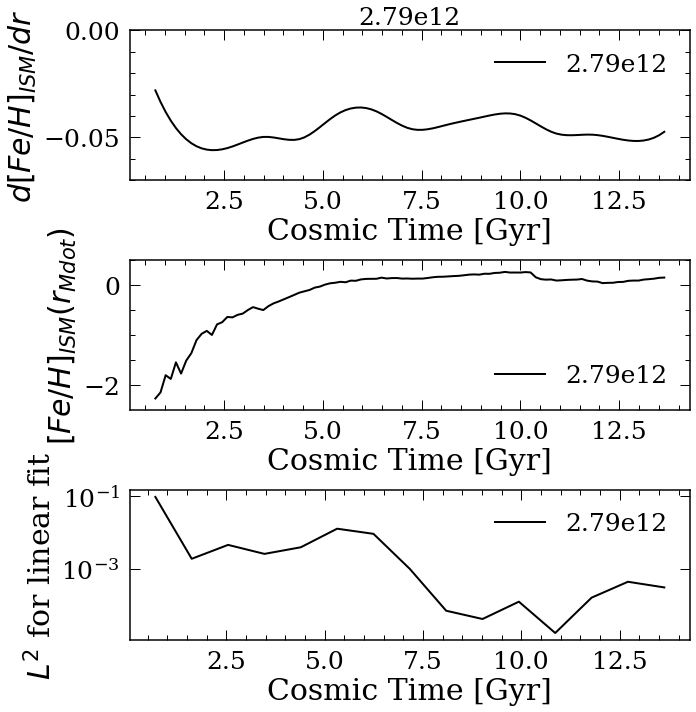

In [94]:
i=4
plt.subplot(3,1,1)
plt.plot(allages[i,:],allfeh_slope[i,:],
         '-',color='k',label=simsnames[i])
plt.ylim([-0.07,0])
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$d[Fe/H]_{ISM}/dr$')
plt.legend()
plt.title(simsnames[i], fontsize=25)

plt.subplot(3,1,2)
plt.plot(allages[i,:],allfeh[i,:],
        '-',color='k',label=simsnames[i])
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$[Fe/H]_{ISM}(r_{Mdot})$')
plt.ylim([-2.5,0.5])
plt.legend()
plt.tight_layout()

plt.subplot(3,1,3)
plt.semilogy(agebin, lsqs[i,:], '-',color='k',label=simsnames[i])
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$L^2$ for linear fit')
plt.legend()
plt.tight_layout()





closest time is: 5.984415637359656
reading snap g2.79e12_3x6/2.79e12.00845


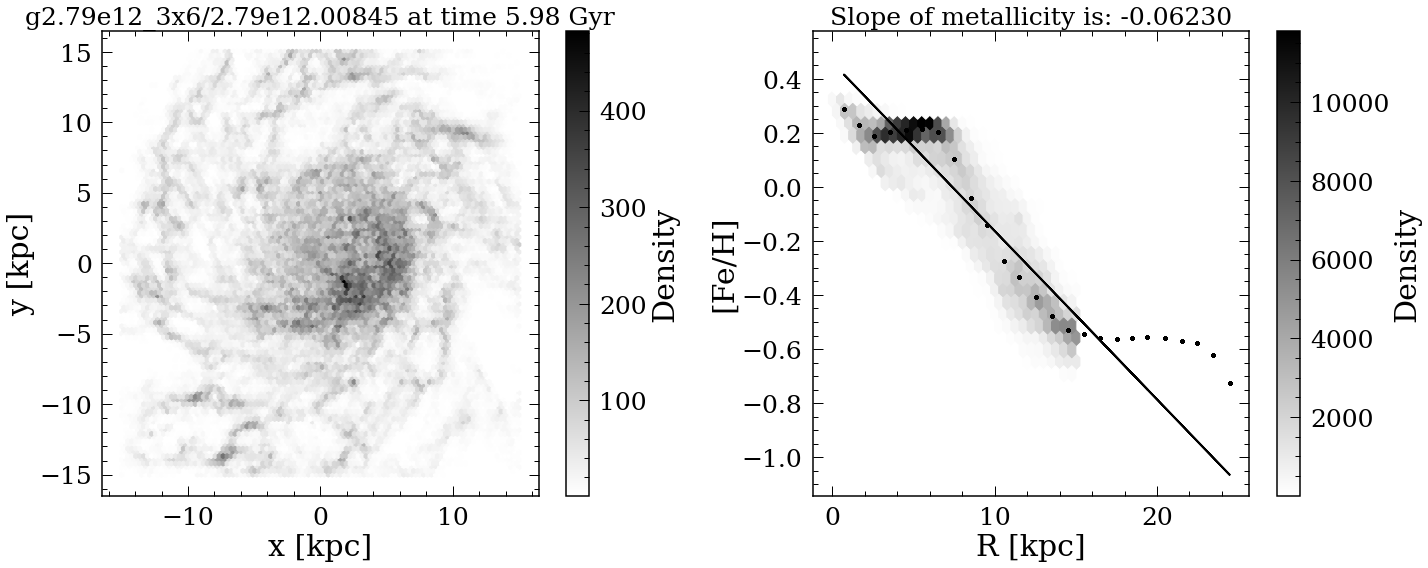

In [97]:
pltFehR_ISM(time2snap, 6)

closest time is: 7.502591513937411
reading snap g2.79e12_3x6/2.79e12.01060


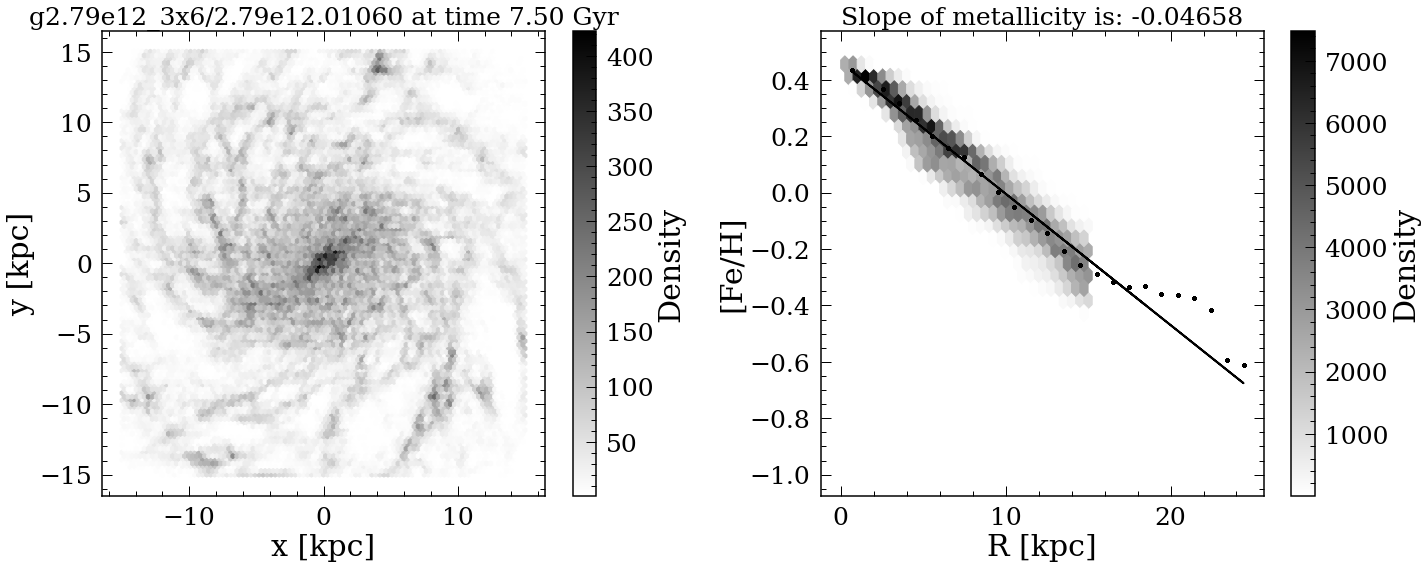

In [98]:
pltFehR_ISM(time2snap, 7.5)

closest time is: 9.974040615342455
reading snap g2.79e12_3x6/2.79e12.01410


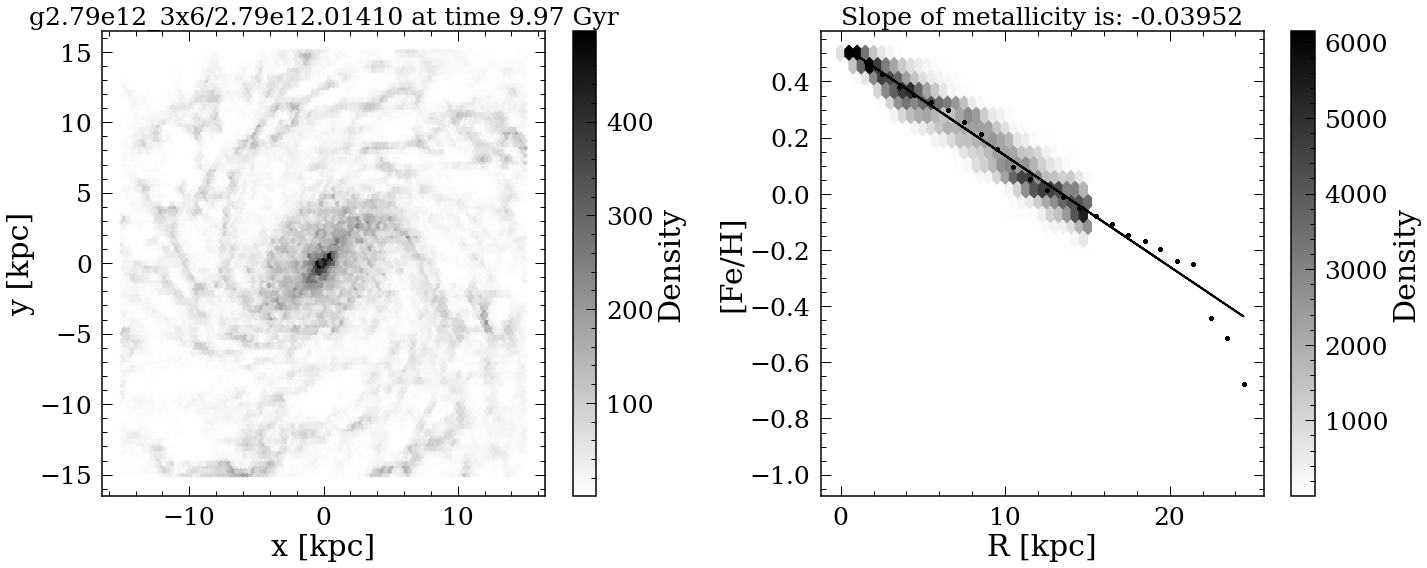

In [100]:
pltFehR_ISM(time2snap, 10)

In [115]:

allage_times_calc = np.array(list(time2snap.keys()), dtype=float)
slopes = np.zeros(len(allage_times_calc))
for i in trange(len(allage_times_calc)):
    slopes[i] = pltFehR_ISM(time2snap, allage_times_calc[i], pltfeh=False)
    

  0%|          | 1/228 [00:00<01:17,  2.93it/s]

no halo!
no halo!


  1%|▏         | 3/228 [00:14<20:22,  5.43s/it]

no gas!


100%|██████████| 228/228 [3:39:13<00:00, 57.69s/it]   


Text(0, 0.5, '$d[Fe/H]_{ISM}/dr$ [dex/kpc]')

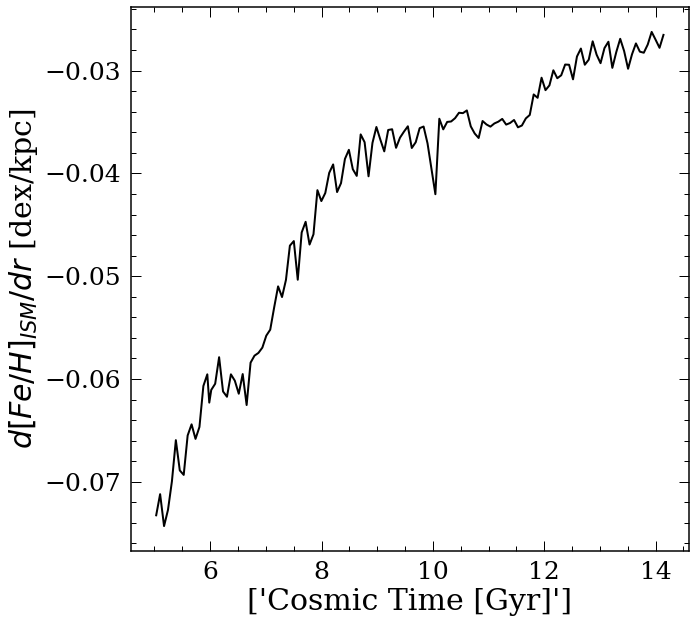

In [123]:
m=allage_times_calc>5
plt.plot(allage_times_calc[m], slopes[m],'k-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$d[Fe/H]_{ISM}/dr$ [dex/kpc]')

In [124]:
(pd.DataFrame(np.array((allage_times_calc, slopes)).T,columns=['time','slope'])).to_pickle('ISM_slope_g279e12.pkl')


In [ ]:
# get all slopes
for i in range(len(sims)):
    if i==4:
        continue
    sim = sims[i]
    print(sim)
    simsname = sim.split('_')[0]
    allsnaps = glob.glob(sim+'/*.?????')

    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    allsnaps_time = sorted(allsnaps_time)
    allages_ism = np.zeros(len(allsnaps_time))

    for i in trange(len(allsnaps_time)):
        s = pb.load(snaplookup[allsnaps_time[i]])
        s.physical_units()
        allages_ism[i] = s.properties['time']

    time2snap = {allages_ism[i]:snaplookup[allsnaps_time[i]] for i in range(len(allsnaps_time))}
    
    
    allage_times_calc = np.array(list(time2snap.keys()), dtype=float)
    slopes = np.zeros(len(allage_times_calc))
    for j in trange(len(allage_times_calc)):
        slopes[j] = pltFehR_ISM(time2snap, allage_times_calc[j], pltfeh=False)
    
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    (pd.DataFrame(np.array((allage_times_calc, slopes)).T,columns=['time','slope'])).to_pickle('ISM_slope_'+name+'.pkl')



        

g6.96e11_3x9


  1%|          | 1/128 [00:00<00:25,  4.96it/s]

no halo!


 62%|██████▏   | 79/128 [1:05:09<51:20, 62.87s/it]